# 1.1 Data

In [75]:
# Imports
import numpy as np
from glob import glob
from os import path
from scipy.special import comb
from scipy.optimize import minimize
from scipy.stats import binom

data_dir = "data"
file_paths = glob(path.join(data_dir, "*.txt"))

# N x M x K
# 5 FILES x 7 ROWS  x 5 COLUMNS
# ROW 1: Audio 
# ROW 2: Visual
# ROW 3-7: Visual going from 'b' (row 3) to 'd' (row 7)
# Columns: Audio from 'b' (col 1) to 'd' (col 5)
data = np.array([np.loadtxt(fname) for fname in file_paths], dtype=np.int64)
N, M, K = data.shape

AUDIO_DATA       = data[:, 0, :]
VISUAL_DATA      = data[:, 1, :]
AUDIOVISUAL_DATA = data[:, 2:, :]

In [76]:
def baseline_softmax(theta):
    e = np.exp(theta)
    return e / (e +1 )

In [77]:
def binomial_pmf(k, n, p):
    return comb(n, k) * np.power(p, k) * np.power(1 - p, n - k)

In [78]:
args = (data[0], 24, np.vstack([p_a.T, p_v.T, p_av]))
np.isclose(binom.logpmf(*args), np.log(binomial_pmf(*args)))

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [79]:
def objective_function(theta, subject_data):
    theta_a = theta[0:K]
    theta_v = theta[K: ]

    p_a = np.array([baseline_softmax(theta) for theta in theta_a]).reshape(-1,1)
    p_v = np.array([baseline_softmax(theta) for theta in theta_v]).reshape(-1,1)
    
    # Outer product for all combinations
    p_av = (p_a @ p_v.T) / (p_a @ p_v.T + (1 - p_a) @ (1 - p_v).T)
    # likelihoods = binom.logpmf(subject_data, 24, np.vstack([p_a.T, p_v.T, p_av]))
    likelihoods = np.log(binomial_pmf(subject_data, 24, np.vstack([p_a.T, p_v.T, p_av])))

    return -(likelihoods.sum())
p_set = []
for i in range(5):
    
    theta = np.random.randn(K*2)
    opt_result = minimize(objective_function, theta, args=(data[i]))
    objective, theta_a, theta_v, success = (
        opt_result.fun, 
        (opt_result.x[0:K]), 
        (opt_result.x[K:]), 
        opt_result.success
    )

    print("Subject ", i)
    print("Converged:",success, "NLL:",objective)
    print("theta_a", theta_a)
    print("theta_v", theta_v)
    p_a = np.array([baseline_softmax(theta) for theta in theta_a]).reshape(-1,1)
    p_v = np.array([baseline_softmax(theta) for theta in theta_v]).reshape(-1,1)
    p_av = (p_a @ p_v.T) / (p_a @ p_v.T + (1 - p_a) @ (1 - p_v).T)
    p_set.append(np.vstack([p_a.T, p_v.T, p_av]))
    print("===")
    print("p_a", p_a.flatten())
    print("p_v", p_v.flatten())
    print("p_av\n", np.round(p_av, 3))
    print("===")
    print("data")
    print(np.round(binom.pmf(data[i][2:], 24, p_av), 3))
    print("\n\n")

Subject  0
Converged: True NLL: 70.2576578605078
theta_a [-4.78771544 -1.95605394 -0.25823504  1.43526737  1.67202776]
theta_v [-1.11834354  0.51165148  1.54670852  4.28161102  5.03519746]
===
p_a [0.00826263 0.12389474 0.43579762 0.80772071 0.84184599]
p_v [0.24631867 0.62519354 0.82443783 0.98636802 0.99353713]
p_av
 [[0.003 0.014 0.038 0.376 0.562]
 [0.044 0.191 0.399 0.911 0.956]
 [0.202 0.563 0.784 0.982 0.992]
 [0.579 0.875 0.952 0.997 0.998]
 [0.635 0.899 0.962 0.997 0.999]]
===
data
[[0.937 0.718 0.398 0.15  0.16 ]
 [0.016 0.044 0.097 0.103 0.198]
 [0.025 0.138 0.196 0.653 0.818]
 [0.163 0.017 0.216 0.924 0.964]
 [0.143 0.059 0.375 0.94  0.971]]



Subject  1
Converged: True NLL: 41.79765647023575
theta_a [-6.55473287 -1.91458349  0.34489206  3.099468    3.87804662]
theta_v [-1.63230368  1.07303227  2.55000124  4.14860416  6.12230246]
===
p_a [0.00142134 0.1284668  0.58537837 0.9568708  0.97972824]
p_v [0.16351502 0.74517314 0.9275736  0.9844589  0.9978114 ]
p_av
 [[0.    0.004

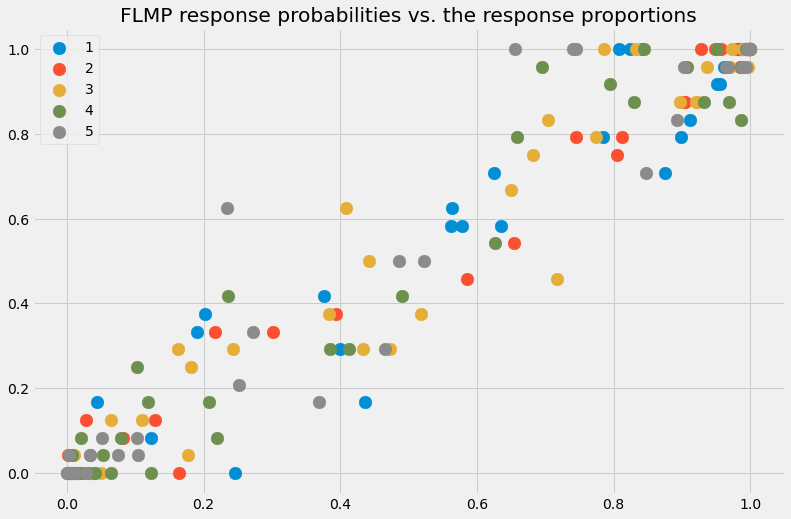

In [126]:

x = p_set
y = list(data/24)

fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(111)


for idx, color in enumerate(colors):
    ax1.scatter(x[idx], y[idx],s=160,label=idx+1)
plt.legend(loc='upper left')
plt.title("FLMP response probabilities vs. the response proportions")
plt.style.use('fivethirtyeight')
plt.show()
